# Intoduction to NLP Fundamentals in Tensorflow

Derive information from text or speech

## Helper Functions

In [1]:
import helper_functions
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

## Evaluation Function

In [2]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate(y_true, preds):

    return {
        "Accuracy Score": (accuracy_score(y_true, preds) * 100),
        "Precision Score": (precision_score(y_true, preds)* 100),
        "Recall Score": (recall_score(y_true, preds)* 100),
        "F1-Score": (f1_score(y_true, preds)* 100)
    }

## Get Text Data Set

In [3]:
# Kaggle's intro to NLP dataset - target [1 - disaster, 0 - not disaster]
import pandas as pd
train_data = pd.read_csv('data/nlp-getting-started/train.csv')
test_data = pd.read_csv("data/nlp-getting-started/test.csv")

## Visualizing Text Dataset

In [4]:
# Shuffle Data
train_data_shuffled = train_data.sample(frac = 1, random_state=42)
train_data_shuffled.head(3)

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1


In [5]:
# Examples from each class?
train_data_shuffled.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [6]:
# Visualize random training examples
import random
random_index = random.randint(0, len(train_data)-5)
for row in train_data_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
    _, text, target = row
    print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
    print(f"Text:\n{text}\n")

Target: 0 (not real disaster)
Text:
Stu Dorret's mudslide rubber tyre cake may have saved you #GBBO

Target: 0 (not real disaster)
Text:
This LA Startup Is So Hot that Their Flowers Come Straight from a Volcano http://t.co/R3PDdjPiEe via @LATechWatch

Target: 0 (not real disaster)
Text:
@carneross indeed and a remarkably puny idea to place at the epicentre of a new post-capitalism epoch

Target: 0 (not real disaster)
Text:
@pxnatosil @RenuncieDilma  Fatality!

Target: 0 (not real disaster)
Text:
'But right now you're only annoyed by them. If you actually hung out with them you'd see that they mean no harm.' @AudaciousSpunk



### Split data into training and validation splits

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# Split training data into train and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_data_shuffled["text"].to_numpy(),
                                                                                train_data_shuffled["target"].to_numpy(), 
                                                                                test_size=0.1, random_state=42)
print(f"Train: {len(train_sentences)}, Validation: {len(val_sentences)}")

Train: 6851, Validation: 762


## Text Vectorization (Tokenization)

In [9]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [10]:
# Find the avg number of tokens (words) in each sequence of the training set

max_lenght = round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))
max_lenght

15

In [11]:
# Setup the vectorization variables
MAX_VOCAB_LENGTH = 10_000
MAX_LENGTH = max_lenght
OUTPUT_MODE = "int"



text_vectorizer = TextVectorization(max_tokens=MAX_VOCAB_LENGTH, # how many words in the vocab
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None,
                                    output_mode=OUTPUT_MODE,
                                    output_sequence_length=MAX_LENGTH, # how long should the sequences be
                                    pad_to_max_tokens=True)

2022-05-30 21:51:09.074129: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [13]:
# Create a sample sentence and tokenize it
sample_sentence = "There is a flood in my street"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 74,   9,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,
          0,   0]])>

## Embedding Layers

Parameter to care for:
* `input_dim`
* `output_dim`
* `input_length`

In [14]:
from tensorflow.keras import layers

OUTPUT_DIM = 128

embedding = layers.Embedding(input_dim = MAX_VOCAB_LENGTH,
                            output_dim = OUTPUT_DIM,
                            input_length = MAX_LENGTH)

In [15]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original Text:\n {random_sentence}\
    \n\nEmbedded Sentence:")

# Embed
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original Text:
 I fail to see how that would not bring the number of road fatalities down IMMENSELY    

Embedded Sentence:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.03900011,  0.03718014, -0.01648239, ...,  0.01260573,
         -0.01358408, -0.01213404],
        [-0.01782079,  0.04413937,  0.03965607, ...,  0.00551749,
          0.04487219, -0.02199703],
        [-0.0431363 , -0.02011384,  0.03721175, ..., -0.04916177,
         -0.00095408,  0.02266815],
        ...,
        [-0.01744239, -0.03556849, -0.02300822, ...,  0.04589213,
         -0.00098292, -0.03430483],
        [-0.04223281,  0.03443266, -0.00579477, ..., -0.04480303,
         -0.03411742, -0.02580704],
        [ 0.01858507, -0.00406301, -0.0001693 , ...,  0.02712229,
          0.03324961, -0.0441456 ]]], dtype=float32)>

## Modelling Text Data - Running Multiple Experiments

* Model 0: Naive Bayes (baseline)
* Model 1: Feed Forward Neural Network (dense network)
* Model 2: LSTM Model (RNN)
* Model 3: GRU Model (RNN)
* Model 4: Bidirectional-LSTM Model (RNN)
* Model 5: 1-D Convolutional Network (CNN)
* Model 6: Transfer Learning (Tensorflow Hub)
* Model 7: Model 6, only 10% of data

### Model 0: Naive Bayes - Baseline Model
* `Multinomial Navie Bayes`

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create Tokenization and Modelling Pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert text to numbers
    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)



Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [17]:
# Evaluate the baseline model

baseline_score = model_0.score(val_sentences, val_labels)
print(f"Baseline model achieves an accuracy of: {baseline_score * 100:.2f}")

Baseline model achieves an accuracy of: 79.27


In [18]:
# Get Baseline Results
baseline_preds = model_0.predict(val_sentences)
baseline_results = evaluate(y_true=val_labels,
                            preds=baseline_preds)
baseline_results

{'Accuracy Score': 79.26509186351706,
 'Precision Score': 88.6178861788618,
 'Recall Score': 62.643678160919535,
 'F1-Score': 73.4006734006734}

### Model 1: Feed-Forward Neural Net (Dense Network)

In [19]:
# Create Tensorboard Callback 
from helper_functions import create_tensorboard_callback

# Create a directory to save TensoBoard API
SAVE_DIR = "model_logs"

In [20]:
# Build a model with the Functional API
from tensorflow.keras import layers

inputs = layers.Input(shape = (1, ), dtype = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model_1 = tf.keras.Model(inputs, outputs, name = "model_1_dense")

In [21]:
# Summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [22]:
# Compile the model
model_1.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [23]:
# Fit the model

model_1_history = model_1.fit(
    x = train_sentences,
    y = train_labels,
    epochs  = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(dir_name = SAVE_DIR,
                                            experiment_name = "model_1_dense")]
)

Saving TensorBoard log files to: model_logs/model_1_dense/20220530-215110
Epoch 1/5
215/215 [==============================] - 5s 19ms/step - loss: 0.6102 - accuracy: 0.6938 - val_loss: 0.5349 - val_accuracy: 0.7546
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.4405 - accuracy: 0.8190 - val_loss: 0.4700 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3465 - accuracy: 0.8619 - val_loss: 0.4583 - val_accuracy: 0.7953
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.2844 - accuracy: 0.8875 - val_loss: 0.4655 - val_accuracy: 0.7874
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.2375 - accuracy: 0.9129 - val_loss: 0.4787 - val_accuracy: 0.7822


In [24]:
model_1_preds_probs = model_1.predict(val_sentences)
model_1_preds_probs.shape


24/24 [==============================] - 0s 7ms/step


(762, 1)

In [25]:
# Convert Porbs to label format
model_1_preds = tf.squeeze(tf.round(model_1_preds_probs))
model_1_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0., 1., 1., 0., 0.], dtype=float32)>

In [26]:
# Evaluate the model
model_1_results = evaluate(val_labels, model_1_preds)
print(f"Model_0 Results:\n {baseline_results}")
print(f"Model_1 Results:\n {model_1_results}")

Model_0 Results:
 {'Accuracy Score': 79.26509186351706, 'Precision Score': 88.6178861788618, 'Recall Score': 62.643678160919535, 'F1-Score': 73.4006734006734}
Model_1 Results:
 {'Accuracy Score': 78.21522309711287, 'Precision Score': 80.95238095238095, 'Recall Score': 68.39080459770115, 'F1-Score': 74.14330218068535}


## Recurrent Neural Networks (RNN's)

* Useful for sequence data
* Premise - Use the representation of a previous input to aid the representation of a later input

### Model 2: LSTM

In [27]:
#  Create LSTM model

from tensorflow.keras import layers

inputs = layers.Input(shape = (1, ), dtype = "string")
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64)(x)
x = layers.Dense(64, activation = "relu")(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name = "model_2_LSTM")

In [28]:
# Get summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                      

In [29]:
# Compile the model
model_2.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [30]:
model_2_history = model_2.fit(
    x = train_sentences,
    y = train_labels,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR,
    "model_2_LSTM")]
)

Saving TensorBoard log files to: model_logs/model_2_LSTM/20220530-215134
Epoch 1/5
215/215 [==============================] - 10s 34ms/step - loss: 0.2250 - accuracy: 0.9245 - val_loss: 0.5871 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 6s 27ms/step - loss: 0.1565 - accuracy: 0.9416 - val_loss: 0.6462 - val_accuracy: 0.7782
Epoch 3/5
215/215 [==============================] - 5s 25ms/step - loss: 0.1278 - accuracy: 0.9526 - val_loss: 0.7901 - val_accuracy: 0.7756
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.1062 - accuracy: 0.9590 - val_loss: 0.8722 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 5s 24ms/step - loss: 0.0863 - accuracy: 0.9657 - val_loss: 0.9262 - val_accuracy: 0.7756


In [31]:
# Calculate results
model_2_results = evaluate(y_true=val_labels,
                           preds=tf.squeeze(tf.round(model_2.predict(val_sentences))))
model_2_results

24/24 [==============================] - 1s 6ms/step


{'Accuracy Score': 77.55905511811024,
 'Precision Score': 76.73716012084593,
 'Recall Score': 72.98850574712644,
 'F1-Score': 74.8159057437408}

In [32]:
baseline_results

{'Accuracy Score': 79.26509186351706,
 'Precision Score': 88.6178861788618,
 'Recall Score': 62.643678160919535,
 'F1-Score': 73.4006734006734}

### Model 3: GRU

In [33]:
from tensorflow.keras import layers

inputs = layers.Input(shape = (1, ), dtype = "string")
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.GRU(64, return_sequences=True)
x = layers.GRU(64)(x)
x = layers.Dense(64, activation = "relu")(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name = "model_3_GRU")

In [34]:
# Model 3 summary
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                       

In [35]:
# Compile the model
model_3.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [36]:
# Fit the model
model_3_history = model_3.fit(
    x = train_sentences, 
    y = train_labels,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR, "model_3_GRU")]
)

Saving TensorBoard log files to: model_logs/model_3_GRU/20220530-215206
Epoch 1/5
215/215 [==============================] - 9s 25ms/step - loss: 0.1481 - accuracy: 0.9461 - val_loss: 0.8831 - val_accuracy: 0.7730
Epoch 2/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0805 - accuracy: 0.9686 - val_loss: 0.9053 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 5s 23ms/step - loss: 0.0721 - accuracy: 0.9736 - val_loss: 0.9240 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0558 - accuracy: 0.9775 - val_loss: 1.2574 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 4s 19ms/step - loss: 0.0573 - accuracy: 0.9739 - val_loss: 1.0403 - val_accuracy: 0.7677


In [37]:
# Evaluate the model
model_3_results = evaluate(y_true = val_labels,
                            preds = tf.squeeze(tf.round(model_3.predict(val_sentences))))
model_3_results

24/24 [==============================] - 0s 3ms/step


{'Accuracy Score': 76.77165354330708,
 'Precision Score': 81.78438661710037,
 'Recall Score': 63.2183908045977,
 'F1-Score': 71.3128038897893}

### Model 4: Bidirectional RNN

In [38]:
from tensorflow.keras import layers

inputs = layers.Input(shape = (1, ), dtype = "string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.GRU(64))(x)
x = layers.Dense(64, activation = "relu")(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name = "model_4_bidirectional")

In [39]:
# Model 4 summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 15, 128)          98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                             

In [40]:
# Compile the model
model_4.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [41]:
# Fit the model
model_4_history = model_4.fit(
    x = train_sentences,
    y = train_labels,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR, "model_4_bidirectional")]
)

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20220530-215235
Epoch 1/5
215/215 [==============================] - 22s 60ms/step - loss: 0.1008 - accuracy: 0.9670 - val_loss: 1.2085 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 13s 61ms/step - loss: 0.0504 - accuracy: 0.9765 - val_loss: 1.2635 - val_accuracy: 0.7664
Epoch 3/5
215/215 [==============================] - 11s 53ms/step - loss: 0.0500 - accuracy: 0.9774 - val_loss: 1.3482 - val_accuracy: 0.7559
Epoch 4/5
215/215 [==============================] - 11s 49ms/step - loss: 0.0428 - accuracy: 0.9803 - val_loss: 1.7628 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 11s 52ms/step - loss: 0.0425 - accuracy: 0.9796 - val_loss: 1.8033 - val_accuracy: 0.7612


In [42]:
# Evaluate the model
model_4_results = evaluate(y_true=val_labels,
                            preds=tf.squeeze(tf.round(model_4.predict(val_sentences))))
model_4_results

24/24 [==============================] - 3s 16ms/step


{'Accuracy Score': 76.11548556430446,
 'Precision Score': 77.66666666666666,
 'Recall Score': 66.95402298850574,
 'F1-Score': 71.91358024691358}

## Convolutional Neural Networks for Text

### Model 5: Conv1D

In [57]:
from tensorflow.keras import layers

inputs = layers.Input(shape = (1, ), dtype = "string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters = 64, kernel_size = 5, strides = 1, 
                    activation = "relu", padding = "valid")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name = "model_5_conv1d")

In [58]:
# Model 5 summary
model_5.summary()

Model: "model_5_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_3 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_average_pooling1d_4   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_10 (Dense)            (None, 1)              

In [59]:
# Compile the model
model_5.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

In [60]:
# Fit the model
model_5_history = model_5.fit(
    x = train_sentences,
    y = train_labels,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR, "model_5_conv1d")]
)

Saving TensorBoard log files to: model_logs/model_5_conv1d/20220530-222111
Epoch 1/5
215/215 [==============================] - 4s 17ms/step - loss: 0.1172 - accuracy: 0.9663 - val_loss: 1.0612 - val_accuracy: 0.7559
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0580 - accuracy: 0.9762 - val_loss: 1.2969 - val_accuracy: 0.7546
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0495 - accuracy: 0.9796 - val_loss: 1.3953 - val_accuracy: 0.7520
Epoch 4/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0462 - accuracy: 0.9787 - val_loss: 1.5736 - val_accuracy: 0.7507
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0440 - accuracy: 0.9801 - val_loss: 1.5535 - val_accuracy: 0.7520


In [61]:
# Evaluate the model
model_5_evaluate = evaluate(y_true=val_labels,
                            preds = tf.squeeze(tf.round(model_5.predict(val_sentences))))
model_5_evaluate

24/24 [==============================] - 0s 3ms/step


{'Accuracy Score': 75.19685039370079,
 'Precision Score': 74.61300309597523,
 'Recall Score': 69.25287356321839,
 'F1-Score': 71.83308494783903}

## Transfer Learning

### Model 6: Tensorflow Hub Pre-trained Universal Sentence Encoder

In [62]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # embed -> because this model helps with embedding, not classification, use dense

In [64]:
# Create sentence encoder layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape = [],
                                        dtype = tf.string,
                                        trainable = False,
                                        name = "USE")

In [71]:
model_6 = tf.keras.Sequential([
                                sentence_encoder_layer,
                                layers.Dense(64, activation = "relu"),
                                layers.Dense(1, activation = "sigmoid")
                            ], name = "model_6_USE")

In [72]:
# Compile the model
model_6.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [73]:
# Fit the model
model_6_history = model_6.fit(
    x = train_sentences,
    y = train_labels,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR, "model_6_USE")]
)

Saving TensorBoard log files to: model_logs/model_6_USE/20220530-231537
Epoch 1/5
215/215 [==============================] - 5s 16ms/step - loss: 0.5016 - accuracy: 0.7876 - val_loss: 0.4498 - val_accuracy: 0.8031
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4137 - accuracy: 0.8171 - val_loss: 0.4352 - val_accuracy: 0.8163
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3999 - accuracy: 0.8228 - val_loss: 0.4332 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3914 - accuracy: 0.8282 - val_loss: 0.4337 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3852 - accuracy: 0.8294 - val_loss: 0.4268 - val_accuracy: 0.8163


In [74]:
# Evaluate the model
model_6_results = evaluate(y_true = val_labels,
                            preds = tf.squeeze(tf.round(model_6.predict(val_sentences))))
model_6_results

24/24 [==============================] - 1s 11ms/step


{'Accuracy Score': 81.62729658792651,
 'Precision Score': 81.90184049079755,
 'Recall Score': 76.72413793103449,
 'F1-Score': 79.22848664688428}

## Real Life - We have little data to work with 🙁

In [86]:
# Split dataset for 10% of the data only
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [88]:
# Check the targets
import numpy as np
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

### Model 7 -> Cloned Model 6

In [89]:
model_7 = tf.keras.models.clone_model(model_6)

#compile model
model_7.compile(loss = "binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ["accuracy"])

In [90]:
# Fit the model
model_7_history = model_7.fit(
    x = train_sentences_10_percent,
    y = train_labels_10_percent,
    epochs = 5,
    validation_data = (val_sentences, val_labels),
    callbacks = [create_tensorboard_callback(SAVE_DIR, "model_7_USE_10_percent_data")]
)

Saving TensorBoard log files to: model_logs/model_7_USE_10_percent_data/20220530-234800
Epoch 1/5
22/22 [==============================] - 5s 64ms/step - loss: 0.6707 - accuracy: 0.6905 - val_loss: 0.6444 - val_accuracy: 0.7585
Epoch 2/5
22/22 [==============================] - 1s 31ms/step - loss: 0.6006 - accuracy: 0.8015 - val_loss: 0.5860 - val_accuracy: 0.7835
Epoch 3/5
22/22 [==============================] - 1s 25ms/step - loss: 0.5271 - accuracy: 0.8146 - val_loss: 0.5323 - val_accuracy: 0.7756
Epoch 4/5
22/22 [==============================] - 1s 29ms/step - loss: 0.4665 - accuracy: 0.8175 - val_loss: 0.5010 - val_accuracy: 0.7756
Epoch 5/5
22/22 [==============================] - 1s 30ms/step - loss: 0.4255 - accuracy: 0.8248 - val_loss: 0.4855 - val_accuracy: 0.7782


In [91]:
# Evaluate the model
model_7_results = evaluate(y_true = val_labels,
                            preds = tf.squeeze(tf.round(model_7.predict(val_sentences))))
model_7_results             

24/24 [==============================] - 4s 18ms/step


{'Accuracy Score': 77.82152230971128,
 'Precision Score': 78.96440129449837,
 'Recall Score': 70.11494252873564,
 'F1-Score': 74.27701674277016}

## All Model Results

In [95]:
all_model_results = pd.DataFrame({
    "Baseline": baseline_results,
    "Model_1_Dense": model_1_results,
    "Model_2_LSTM": model_2_results,
    "Model_3_GRU": model_3_results,
    "Model_4_bidirectional": model_4_results,
    "Model_5_Conv1D": model_5_evaluate,
    "Model_6_USE": model_6_results,
    "Model_7_USE_10%": model_7_results
})
all_model_results = all_model_results.transpose()
all_model_results

,Accuracy Score,Precision Score,Recall Score,F1-Score
Baseline,79.265092,88.617886,62.643678,73.400673
Model_1_Dense,78.215223,80.952381,68.390805,74.143302
Model_2_LSTM,77.559055,76.737160,72.988506,74.815906
Model_3_GRU,76.771654,81.784387,63.218391,71.312804
Model_4_bidirectional,76.115486,77.666667,66.954023,71.913580
Model_5_Conv1D,75.196850,74.613003,69.252874,71.833085
Model_6_USE,81.627297,81.901840,76.724138,79.228487
Model_7_USE_10%,77.821522,78.964401,70.114943,74.277017


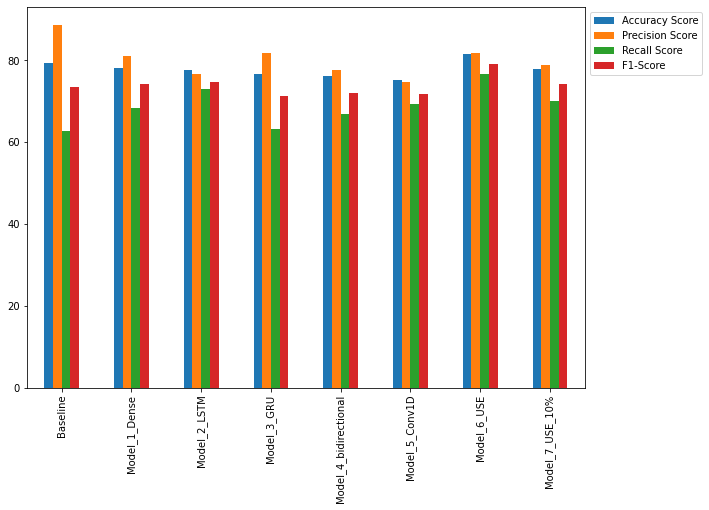

In [96]:
all_model_results.plot(kind = "bar", figsize = (10, 7)).legend(bbox_to_anchor = (1.0, 1.0));

## Save and Load NLP Models
* HDF5 Format
* The `Save Model` format - default

In [97]:
# Save model
# model_6.save("models/model_6.h5")

In [98]:
# Load this model in hdf5 format
# loaded_model_6 = tf.keras.models.load_model("models/model_6.h5",
#                                             custom_objects = {"KerasLayer": hub.KerasLayer})

In [99]:
# Save Model Format
# model_6.save("models/model_6_savedmodels_format")

INFO:tensorflow:Assets written to: models/model_6_savedmodels_format/assets


INFO:tensorflow:Assets written to: models/model_6_savedmodels_format/assets


In [100]:
# loaded_model_6_saved_model = tf.keras.models.load_model("models/model_6_savedmodels_format")

## Finding the most wrong answer examples
* If our best model is not perfect, what examples are it getting wrong
* Which ones are the most wrong

In [102]:
# Create a dataframe with validation sentences, labels and best performing model predictions and probabilities

val_df = pd.DataFrame({
    "text": val_sentences,
    "labels": val_labels,
    "predictions": tf.squeeze(tf.round(model_6.predict(val_sentences))),
    "probabilities": tf.squeeze(model_6.predict(val_sentences))
})
val_df

24/24 [==============================] - 0s 12ms/step


,text,labels,predictions,probabilities
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.258606
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.844572
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.992562
3,@camilacabello97 Internally and externally scr...,1,0.0,0.223227
4,Radiation emergency #preparedness starts with ...,1,1.0,0.774475
...,...,...,...,...
757,That's the ultimate road to destruction,0,0.0,0.124211
758,@SetZorah dad why dont you claim me that mean ...,0,0.0,0.134450
759,FedEx will no longer transport bioterror patho...,0,1.0,0.927575
760,Crack in the path where I wiped out this morni...,0,1.0,0.677772


In [103]:
# Find wrong preds, and sort by pred probs
most_wrong = val_df[val_df["labels"] != val_df["predictions"]].sort_values("probabilities", ascending = False)
most_wrong

,text,labels,predictions,probabilities
759,FedEx will no longer transport bioterror patho...,0,1.0,0.927575
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.922627
628,@noah_anyname That's where the concentration c...,0,1.0,0.908378
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.871318
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.856082
...,...,...,...,...
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.050709
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.046186
38,Why are you deluged with low self-image? Take ...,1,0.0,0.044266
233,I get to smoke my shit in peace,1,0.0,0.044215


## Predictions on Test Data

In [104]:
test_sentences = test_data["text"].to_list()

# Making predictions of 10 test sentences and visualizing them
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
    pred_probs = tf.squeeze(model_6.predict([test_sample]))
    pred = tf.round(pred_probs)
    print(f"Pred: {int(pred)}, Prob: {pred_probs}\n")
    print(f"Text: {test_sample}\n")
    print("-----\n")

1/1 [==============================] - 0s 59ms/step
Pred: 0, Prob: 0.048589110374450684

Text: Beauty Deals : http://t.co/eUd317Eptp #4552 Lot of 50Mixed Colors 7.5' Scissors FirstAid Princess Care Rescue TrÛ_ http://t.co/mAHkV79SmW

-----

1/1 [==============================] - 0s 74ms/step
Pred: 1, Prob: 0.6504212617874146

Text: Stop using the money of tax layers of the country to feed bloody terrorist. Shot them and give a strong msg as other country does...

-----

1/1 [==============================] - 0s 74ms/step
Pred: 0, Prob: 0.05033646896481514

Text: My boy @Fall_off_Cliff still got it man rumor has it he going back to DE ??

-----

1/1 [==============================] - 0s 64ms/step
Pred: 0, Prob: 0.07740994542837143

Text: @eliistender10 @Splats although originally an April Fools jokethey're seriously considering making them after being inundated with requests

-----

1/1 [==============================] - 0s 156ms/step
Pred: 1, Prob: 0.5752593278884888

Text: Kimanzi_: 

In [118]:
# View Test Data
test_data[["text", "id"]].head()

,text,id
0,Just happened a terrible car crash,0
1,"Heard about #earthquake is different cities, s...",2
2,"there is a forest fire at spot pond, geese are...",3
3,Apocalypse lighting. #Spokane #wildfires,9
4,Typhoon Soudelor kills 28 in China and Taiwan,11


In [114]:
# View Submission File - Kaggle
sub_file = pd.read_csv("data/nlp-getting-started/sample_submission.csv")
print(sub_file.columns)
sub_file.head()

Index(['id', 'target'], dtype='object')


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [124]:
submission_file = pd.DataFrame({
    "id": test_data["id"],
    "target": tf.squeeze(tf.round(model_6.predict(test_data["text"].to_list())))
})
submission_file["target"] = submission_file["target"].astype(int)
submission_file.head()

102/102 [==============================] - 1s 11ms/step


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [125]:
submission_file.to_csv("data/nlp-getting-started-submission-1.csv", index = False) # 0.80570 -> accuracy

## Predicting on Tweets from Twitter

In [110]:
sentence = "Tesla Plaid S cruising around Austin with volume at 11 is sublime" #thanks elon

answer = int(tf.squeeze(tf.round(model_6.predict([sentence]))))
print(f"Elon's Tweet is: {answer}")

1/1 [==============================] - 0s 41ms/step
Elon's Tweet is: 0
